# Assignment 2 - Spatial Data Analysis for Summer/Winter
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import libraries

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg 
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File¶

In [2]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [3]:
ct_shape.crs = from_epsg(4326) #epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788 * 10 ** 7) # from ft2 to mi2 
print ('total NYC land area: %s mi^2'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 mi^2


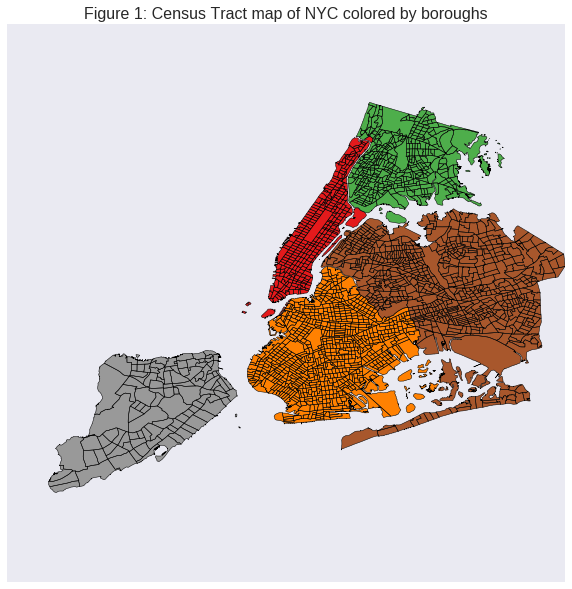

In [4]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha = 1, linewidth = 0.5, ax = ax)
plt.title("Figure 1: Census Tract map of NYC colored by boroughs", fontsize = 16)

## Figure 1: 
### The above figure plots of map of the five boroughs of New York city. Red, green, brown, orange, and gray represent Manhattan, the Bronx, Queens, Brooklyn, and Staten Island, respectively.

### Map NYC Population density

#### Load Census Data for 2010

In [5]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


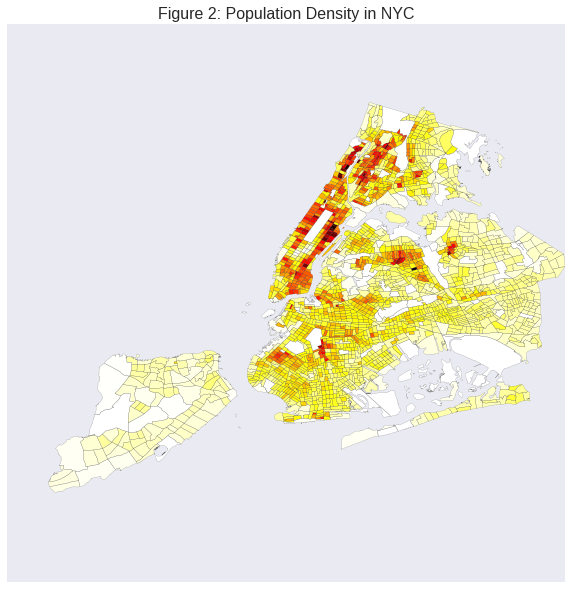

In [7]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column = 'SE_T002_002', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 2: Population Density in NYC", fontsize = 16)

## Figure 2:
### The above figure plots a map of New York City showing population density using a heat scale. Darker red indicates a higher population densities in that census tract, while lighter colors indicate lower densities. Population density appears highest in Manhattan around Central Park (particularly the east side) and in parts of the Bronx, while Staten Island appears to have the lowest population densities in their census tracts.  

## Explore CitiBike data

### Load CitiBike data

In [8]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


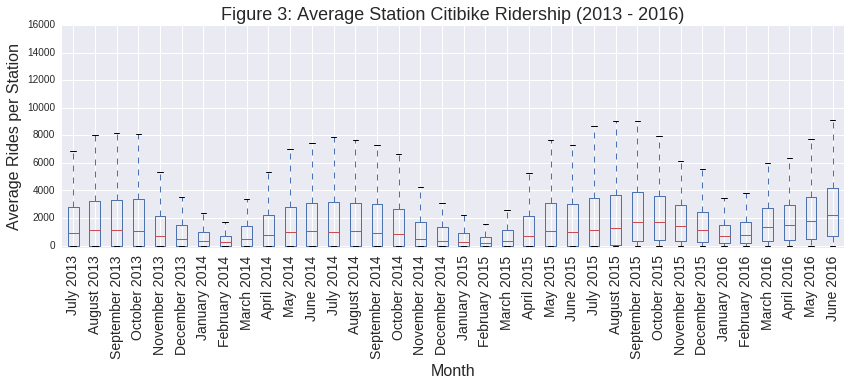

In [9]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize = (15,7), ax = ax, rot = 90);
ax.set_ylim([-200,16000])
ax.set_title('Figure 3: Average Station Citibike Ridership (2013 - 2016)', fontsize = 18)
ax.set_ylabel('Average Rides per Station', fontsize = 16)
ax.set_xlabel('Month', fontsize = 16)

## Figure 3:
### The above plot shows a time series for Citibike data in NYC by month from 2013 to 2016. Each month's value is the average number of rides across all stations. Each month includes a boxplot showing the median (red line), the first and third quartiles (bottom and top of box), as well as the minimum and maximum rides at any station (the ends of the dashed lines). We can see a clear periodic trend of ridership increasing during the summer months and dropping during the winter.

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


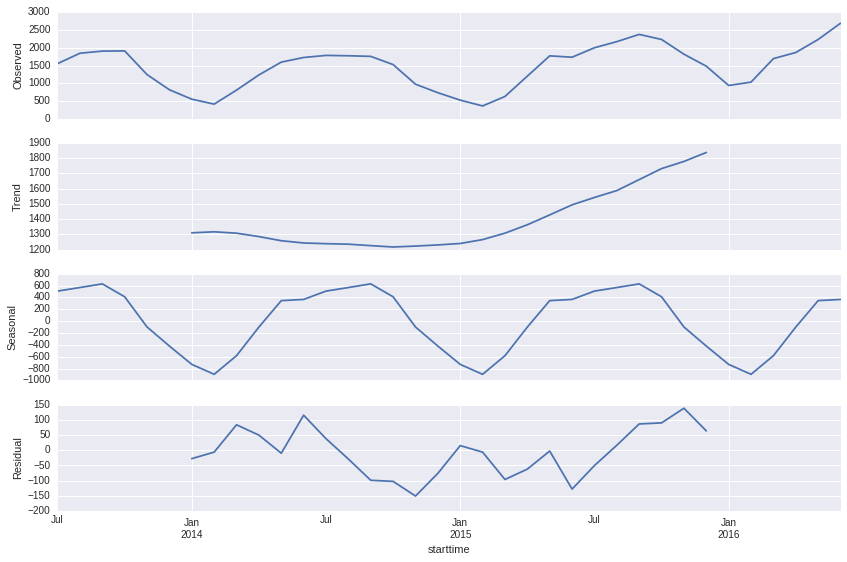

In [10]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

## Figure 4: Seasonal Decomposition of Citibike Data in NYC
### The above set of figures show a data decomposition of observed Citibike ridership data over time. The x axis shows time in 6 month intervals from 2013 to 2016, and the y axis numbers represent the average rides per station, as in Figure 3. The first plot shows the smoothed trends from Figure 3, with a clear seasonal periodicity appearing. The next three plots beneath this break the observed data into the following components: the trend in ridership, seasonal differences, and any residual data. The residual values fall at or less than 150 average rides from 0, much smaller than the overal signal we are seeing, which is a good sign that the trend and the seasonal components are actually creating the observed trend instead of change. The trend line appears to be increasing, indicating ridership on average is likely going up, while the seasonal component shows a clear increase in summer and decrease in winter. 

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [11]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [12]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [13]:
a = []
""" check for each citibike stations to see what CT they are belong to 
"""
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
station_id['BoroCT2010'] = a

In [14]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add seasonal rides to the station GeoDataFrame with CT code

In [15]:
# Creating a new df for summer months
# Defining summer months by Google definition (June through August)
df_bike_monthly_summer = pd.concat([df_bike_monthly.iloc[:2], df_bike_monthly.iloc[11:14], df_bike_monthly.iloc[23:26], 
                                    df_bike_monthly.iloc[35:36]])
df_bike_monthly_summer

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,0,0
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,0
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,0
2015-06-30,2309,0,9457,3426,5859,4763,1809,5190,2695,2116,...,0,0,0,0,0,0,0,0,0,0
2015-07-31,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,0,0
2015-08-31,2640,3799,11801,4288,7031,5417,2470,6306,4583,2838,...,0,0,0,0,0,0,0,0,0,0
2016-06-30,3399,7370,10130,4566,7420,5775,2429,6037,0,3054,...,1036,0,0,7009,1109,665,2470,178,852,615


In [16]:
# Creating a new df for winter months
# Defining winter months by Google definition (Dec through Feb)
df_bike_monthly_winter = pd.concat([df_bike_monthly.iloc[5:8], df_bike_monthly.iloc[17:20], df_bike_monthly.iloc[29:32]])
df_bike_monthly_winter

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,0
2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,619,...,0,0,0,0,0,0,0,0,0,0
2015-02-28,562,0,2130,913,1363,1140,356,1023,891,447,...,0,0,0,0,0,0,0,0,0,0
2015-12-31,1873,2502,7101,2678,3968,3492,1420,3620,3251,1654,...,0,0,0,0,0,0,0,0,0,0
2016-01-31,1031,1669,4533,1847,2304,1943,656,2485,0,935,...,0,0,0,0,0,0,0,0,0,0
2016-02-29,1200,1951,4913,2088,2503,2224,859,2814,0,1082,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Creating average seasonal rides column from citibike data and adding it to the station id which has the geometry
station_id['SummerAve'] = df_bike_monthly_summer.sum()

station_id['WinterAve'] = df_bike_monthly_winter.sum()

In [18]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890,21889


### Add the seasonal average rides to the CT shapefile 

In [19]:
summer_temp = station_id[['SummerAve']]
summer_temp['station_id'] = station_id.index
summer_temp.index = station_id['BoroCT2010']
ct_shape_SummerAve = ct_shape.join(summer_temp)
ct_shape_SummerAve.fillna(0, inplace = True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


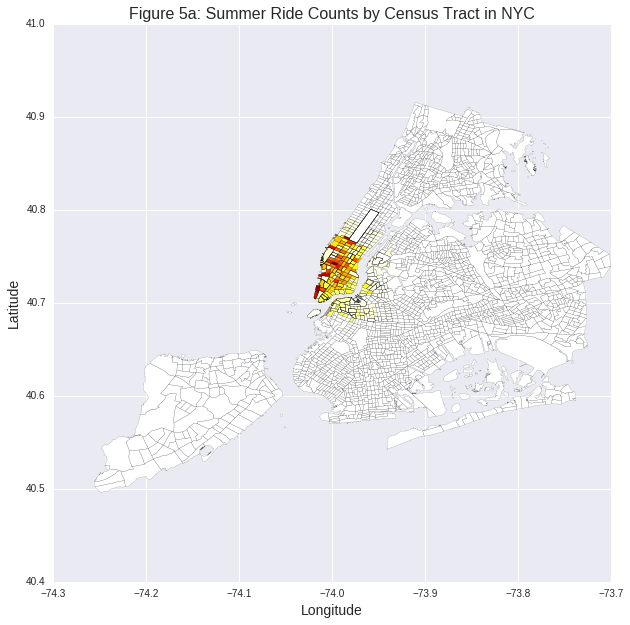

In [20]:
f, ax = plt.subplots(figsize = (10,10))
ct_shape_SummerAve.plot(column = 'SummerAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 5a: Summer Ride Counts by Census Tract in NYC", fontsize = 16)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)

## Figure 5a:
### The above plot shows the average summer rides for each census tract in NYC. The data is in a heat color scale, where darker colors indicate more rides and lighter colors less. It is clear that there are fewer summer riders outside of southern Manhattan than within.

In [21]:
winter_temp = station_id[['WinterAve']]
winter_temp['station_id'] = station_id.index
winter_temp.index = station_id['BoroCT2010']
ct_shape_WinterAve = ct_shape.join(winter_temp)
ct_shape_WinterAve.fillna(0, inplace = True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


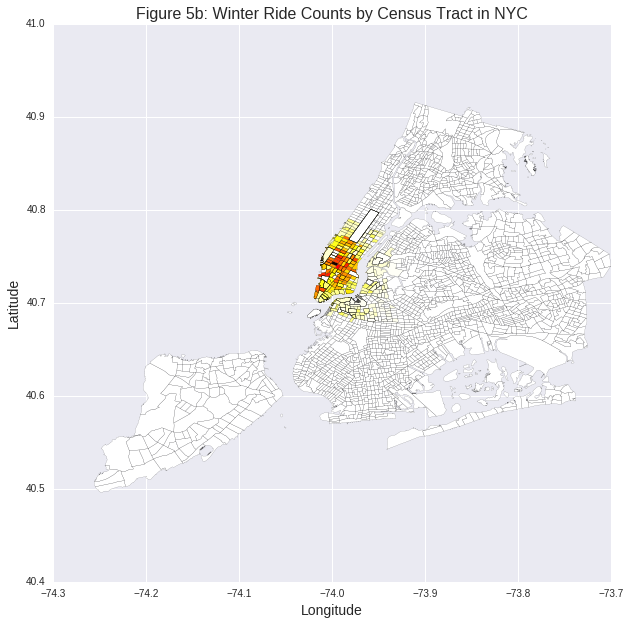

In [22]:
f, ax = plt.subplots(figsize = (10,10))
ct_shape_WinterAve.plot(column = 'WinterAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 5b: Winter Ride Counts by Census Tract in NYC", fontsize = 16)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)

## Figure 5b:
### The above plot shows the average winter rides for each census tract in NYC. The data is in a heat color scale, where darker colors indicate more rides and lighter colors less. Like the summer data, t is clear that there are fewer winter riders outside of southern Manhattan than within.

### Removing the CTs that are out of zoom boundries

In [23]:
ct_shape_SummerAve_Zoom = (ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [24]:
shape_len = len(ct_shape)
summertemp_len = len(summer_temp.SummerAve)

print ('Total number of CTs:', shape_len)
print ('Number of zoomed CTs:', summertemp_len)

Total number of CTs: 2166
Number of zoomed CTs: 543


In [25]:
ct_shape_WinterAve_Zoom = (ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [26]:
shape_len = len(ct_shape)
wintertemp_len = len(winter_temp.WinterAve)

print ('Total number of CTs:', shape_len)
print ('Number of zoomed CTs:', wintertemp_len)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

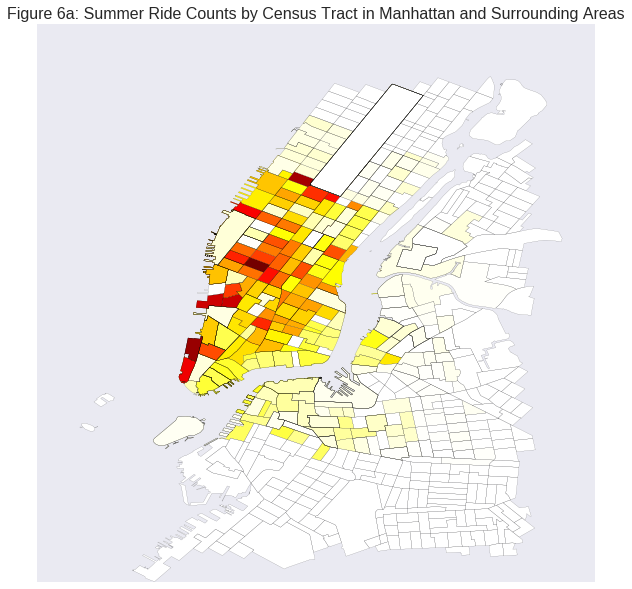

In [27]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_SummerAve_Zoom.plot(column = 'SummerAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 6a: Summer Ride Counts by Census Tract in Manhattan and Surrounding Areas", fontsize = 16)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)

## Figure 6a:
### The above plot shows the zoomed-in portion of Figure 5a, displaying only Manhattan and some of the surrounding census tracts of nearby neighborhoods in order to look more closely at the higher ridership tracts during the summer. From this visualization, we can see that parts of southern midtown, southern Central Park, and some key areas along the southwestern piers (likely those with views of the harbor/Lady Liberty) have the highest summer ride counts. 

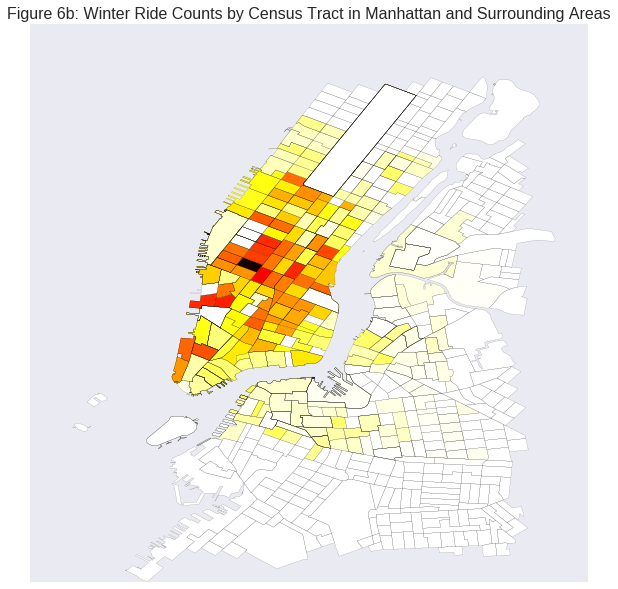

In [28]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column = 'WinterAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 6b: Winter Ride Counts by Census Tract in Manhattan and Surrounding Areas", fontsize = 16)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)

## Figure 6b:
### The above plot shows the zoomed-in portion of Figure 5a, displaying only Manhattan and some of the surrounding census tracts of nearby neighborhoods in order to look more closely at the higher ridership tracts during the winter. Like in the summer map, we can see here that parts of southern midtown, southern Central Park, and some key areas along the southwestern piers (likely those with views of the harbor/Lady Liberty) have the highest winter ride counts. However, their color gradients tend to be lower in some tracts (noteably along the pier and below Central Park), but the patterns are generally the same between seasons, geographically.

### Export Shapefile CTs in the CitiBike Zone

In [29]:
summer_path = 'Output/ct_shape_SummerAve_Zoom.shp'
ct_shape_SummerAve_Zoom.to_file(summer_path)

In [30]:
winter_path = 'Output/ct_shape_WinterAve_Zoom.shp'
ct_shape_WinterAve_Zoom.to_file(winter_path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [31]:
qW_CT_summer = ps.queen_from_shapefile(summer_path)

('Island id: ', [0])


In [32]:
qW_CT_winter = ps.queen_from_shapefile(winter_path)

('Island id: ', [0])


#### Neighbors of index10

In [33]:
qW_CT_summer[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [34]:
qW_CT_summer.cardinalities[10]

9

In [35]:
qW_CT_winter[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [36]:
qW_CT_winter.cardinalities[10]

9

#### Matrix of Weights

In [37]:
Wmatrix1, ids1 = qW_CT_summer.full()

In [38]:
Wmatrix2, ids2 = qW_CT_winter.full()

In [39]:
Wmatrix1

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [40]:
Wmatrix2

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [41]:
qW_CT_summer.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


In [42]:
qW_CT_winter.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [43]:
SummerRide = ct_shape_SummerAve_Zoom.SummerAve
SummerRideLag = ps.lag_spatial(qW_CT_summer, SummerRide)

In [44]:
WinterRide = ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag = ps.lag_spatial(qW_CT_winter, WinterRide)

#### Create Quantiles for maping

In [45]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [46]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

#### Map the seasonal rides lag

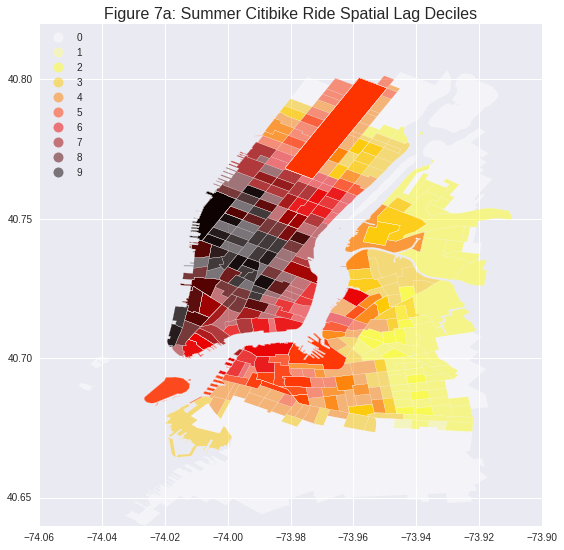

In [47]:
f, ax = plt.subplots(figsize = (9, 9))
ct_shape_SummerAve_Zoom.assign(cl = SummerRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
plt.title("Figure 7a: Summer Citibike Ride Spatial Lag Deciles", fontsize = 16)

## Figure 7a:
### The map above shows spatial lag of average summer Citibike rides for each census tract in Manhattan and the surrounding areas from 2013 to 2016. Lag is essentially the average of the tracts around them (their 'neighboring' tracts). This data is also in the form of a heat map, where darker colors (closer to black) show higher lag in that tract while lighter colors (closer to white) show lower lag. *Something to note is a slight 'glitch' in the system that can be seen by looking at Governor's Island - it has no surrounding tracts, so it should theoretically appear white. However, because part of its census tract also includes parts of Brooklyn's mainland, its lag includes the neighboring tracts surrounding those areas, and the island itself is show with the same colored lag.* Generally, lag is highest in southern midtown Manhattan and along the Hudson in southern Manhattan, and decreases out in Queens, Brooklyn, and northern Manhattan. There are some areas of Brooklyn along the East River and also Central Park that have fairly high lag values too.

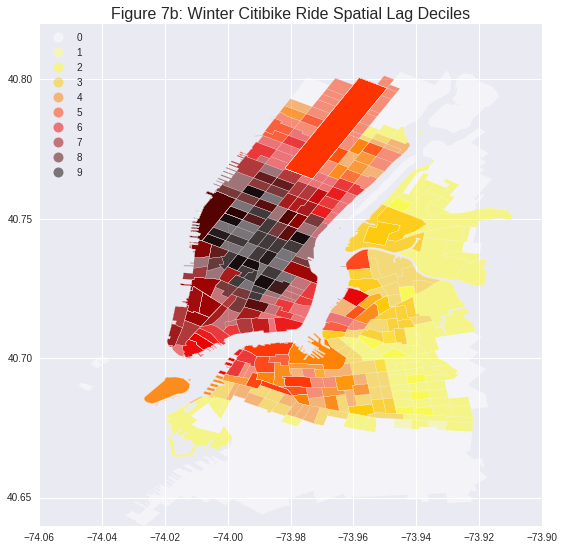

In [48]:
f, ax = plt.subplots(figsize = (9, 9))
ct_shape_WinterAve_Zoom.assign(cl = WinterRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
plt.title("Figure 7b: Winter Citibike Ride Spatial Lag Deciles", fontsize = 16)

## Figure 7b:
### The map above shows spatial lag of average winter Citibike rides for each census tract in Manhattan and the surrounding areas from 2013 to 2016. The largest difference visible here from the summer lag map is that the lag has decreased along the Hudson River in southern Manhattan.

## Global  Spatial Autocorrelation

In [49]:
b1,a1 = np.polyfit(SummerRide, SummerRideLag, 1)
b1,a1 

(0.64335490815356511, 4220.5552980795601)

In [50]:
b2,a2 = np.polyfit(WinterRide, WinterRideLag, 1)
b2,a2 

(0.66023249858156818, 1600.8324238675889)

### Moran Scatterplot

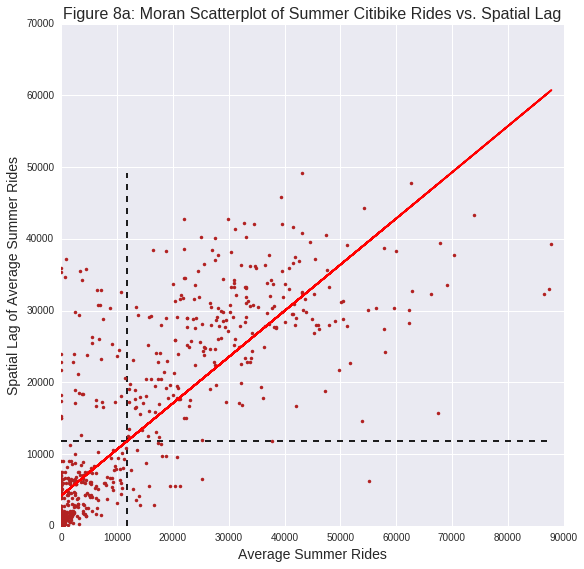

In [51]:
f, ax = plt.subplots(1, figsize = (9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a1 + b1 * SummerRide, 'r')
plt.title('Figure 8a: Moran Scatterplot of Summer Citibike Rides vs. Spatial Lag', fontsize = 16)
plt.ylabel('Spatial Lag of Average Summer Rides', fontsize = 14)
plt.xlabel('Average Summer Rides', fontsize = 14)

## Figure 8a:
### The plot above shows a Moran scatterplot of average summer Citibike rides vs. its spatial lag. Each dot represents a census tract (its own average summer rides plotted against its corresponding lag, or the average of its neighbors). The dashed black gridlines show the Moran divisions - the upper right being tracts with high ridership and neighbors with high ridership; the upper left being tracts with lower ridership but neighbors with high ridership; the lower left being tracts with both low ridership and neighbors with low ridership, and the lower right being tracts with high ridership but neighbors with low ridership, all during the summer months. The red line is a line of best fit, or Moran's I. It is clear that many tracts are clustering in the lower left box (near zero), and others are less dense but clearly trending in the upper right box. The best fit line supports this, going through both of these boxes and indicating that tracts with high ridership tend to also have neighboring tracts with high ridership, and tracts with lower ridership tend to have neighboring tracts with low ridership; a positive correlation between rides and lag. 

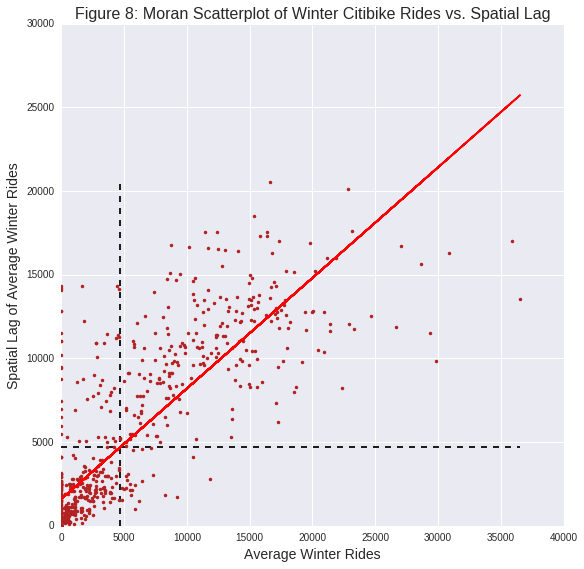

In [52]:
f, ax = plt.subplots(1, figsize = (9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a2 + b2 * WinterRide, 'r')
plt.title('Figure 8: Moran Scatterplot of Winter Citibike Rides vs. Spatial Lag', fontsize = 16)
plt.ylabel('Spatial Lag of Average Winter Rides', fontsize = 14)
plt.xlabel('Average Winter Rides', fontsize = 14)

## Figure 8b:
### The plot above shows a Moran scatterplot of average winter Citibike rides vs. its spatial lag. All explanations of visual representations from Figure 8a's caption apply here. Like above, it is clear that many tracts are clustering in the lower left box (near zero), and others are less dense but clearly trending in the upper right box. The best fit line supports this, going through both of these boxes and indicating that tracts with high ridership tend to also have neighboring tracts with high ridership, and tracts with lower ridership tend to have neighboring tracts with low ridership; a positive correlation between rides and lag. An important difference to note from the summer plot is that the values along each axis are lower in the winter plot (meaning less rides occured overall), even though the pattern appears the similar at first glance.

### Moran's I

In [53]:
I_SummerRide = ps.Moran(SummerRide, qW_CT_summer)

In [54]:
I_SummerRide.I, I_SummerRide.p_sim

(0.64353398667011008, 0.001)

In [55]:
I_WinterRide = ps.Moran(WinterRide, qW_CT_winter)

In [56]:
I_WinterRide.I, I_WinterRide.p_sim

(0.66039156431885593, 0.001)

### The two values of the Moran's I output represent, respectively: Moran's I (or loosely the best fit line) and the p-value, which tells how significant I is (or how likely this line is to occur vs. a random line). 

### For the summer data, the I statistic is 0.0644, and for the summer data the I statistics is 0.660. Both have very small p-values, indicating that both statistics are significant and our Moran's I line is a good fit for each dataset.

In [57]:
I_SummerRide.sim[0:10]

array([ 0.00269401, -0.01603013, -0.03777345,  0.01599547, -0.02292743,
       -0.01195386, -0.00529059,  0.02250265, -0.00262069,  0.00880589])

In [58]:
I_WinterRide.sim[0:10]

array([ 0.04907738, -0.01568323,  0.00511351, -0.00835796,  0.00044561,
        0.00170281, -0.00614108, -0.02898756,  0.00952884, -0.01260633])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [59]:
plt.rcParams['figure.figsize'] = (14,3)

(-0.7, 0.7)

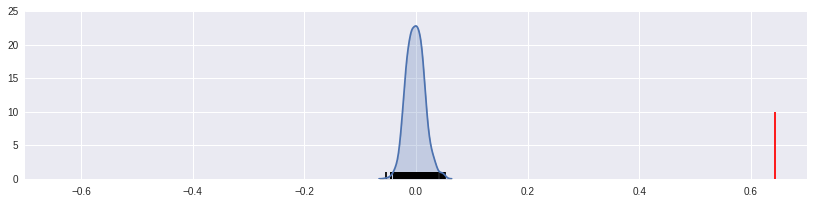

In [60]:
sns.kdeplot(I_SummerRide.sim, shade = True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

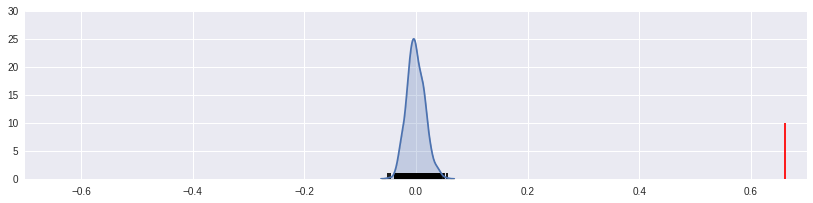

In [61]:
sns.kdeplot(I_WinterRide.sim, shade = True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

## KDE Plots (above):
### The first and second graphs above show Kernal Density Estimation plots for summer and winter, respectively. Because the red lines above (our I statistics) are both very far from the KDE plots (which show the expected density of observations after many random repeats), we can see visually that our I statistics are significant for both summer and winter biking data. Thus, the trend in the Moran scatterplots above and their conclusions are significant.

## In the following figure the vertical line is showing if our I statistics were close to our expected values:

(-0.7, 0.7)

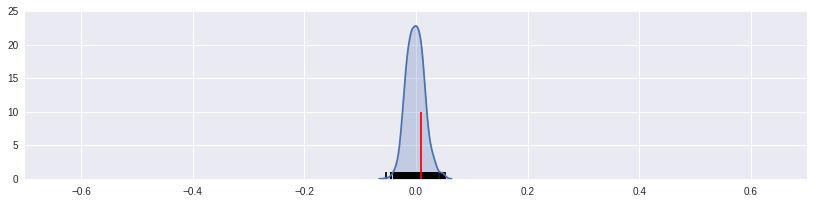

In [62]:
sns.kdeplot(I_SummerRide.sim, shade = True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

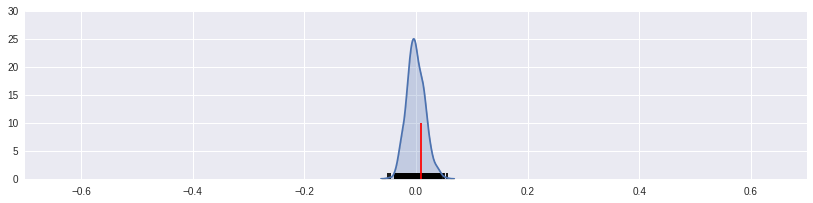

In [63]:
sns.kdeplot(I_WinterRide.sim, shade = True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

### Like the Moran analysis above, but here we're looking at individual census tracts instead of all at once. In other words, it will tell us if an individual census tract is a significant hotspot or not.

In [64]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT_summer, permutations=999)

In [65]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.175,  0.328,  0.357,  0.346]))

In [66]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT_winter, permutations=999)

In [67]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.144,  0.456,  0.49 ,  0.395]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [68]:
# Here we set the significant levels for the individual tracts and their neighboring tracts, 
# both for significant and insignificant p-values, for the summer data
sigs_summer = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs_summer = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs_summer = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs_summer = SummerRideLag[LMo_SummerRide.p_sim > .001]

In [69]:
# Here we set the significant levels for the individual tracts and their neighboring tracts, 
# both for significant and insignificant p-values, for the winter data
sigs_winter = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs_winter = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs_winter = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs_winter = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

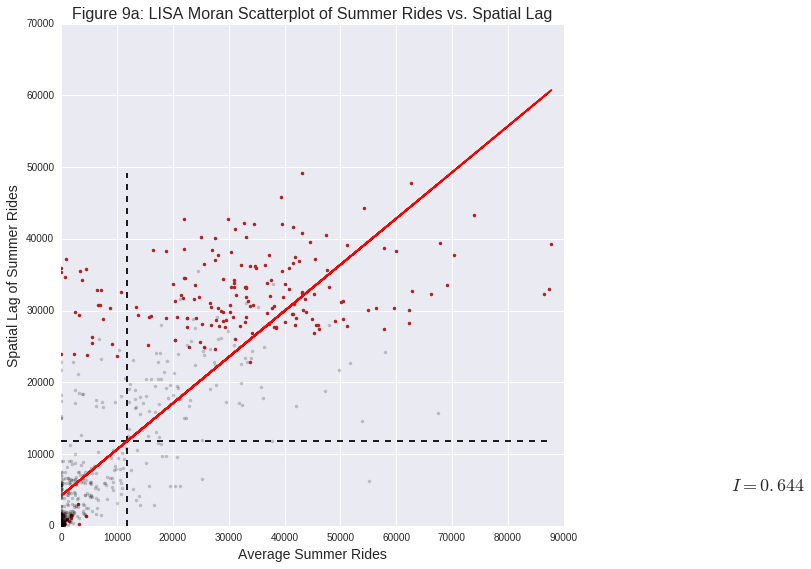

In [70]:
f, ax = plt.subplots(figsize = (9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color = 'firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha = .2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x = 120000, y = 5000, fontsize = 18)

# dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle = '--')
# dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a1 + b1 * SummerRide, 'r')
plt.title('Figure 9a: LISA Moran Scatterplot of Summer Rides vs. Spatial Lag', fontsize = 16)
plt.ylabel('Spatial Lag of Summer Rides', fontsize = 14)
plt.xlabel('Average Summer Rides', fontsize = 14)


## Figure 9a:
### The above plot shows the same Moran Scatterplot as in Figure 8a, but from the LISA analysis we are able to highlight which census tracts are significant or not. The red points indicate that the tract is a significant hot (or cold) spot, while the lighter gray dots are not significant. We can see that the significant census tracts include those were neighboring rides was above about 20000 during the summers, regardless of the individual tract's number of rides. Also, it seems a few tracts with lower rides and lower lag were significant cold spots. From this it would seem that high lag leads to a census tract's Moran scatter location to be more significant.

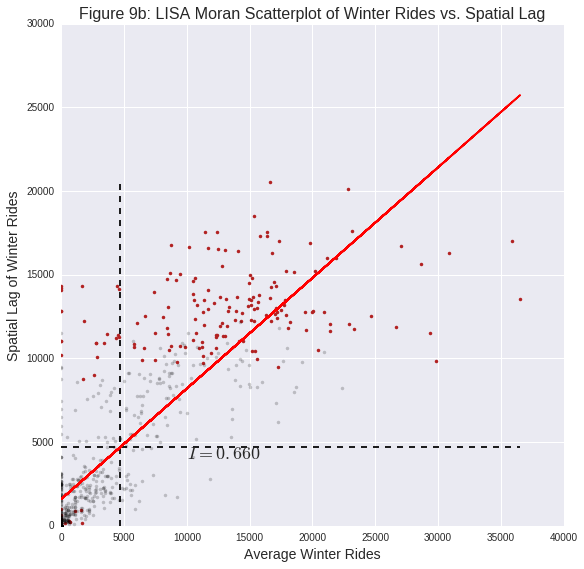

In [77]:
f, ax = plt.subplots(figsize = (9, 9))
plt.plot(sigs_winter, W_sigs_winter, '.', color = 'firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha = .2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x = 10000, y = 4000, fontsize = 18)

# dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle = '--')
# dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a2 + b2 * WinterRide, 'r')
plt.title('Figure 9b: LISA Moran Scatterplot of Winter Rides vs. Spatial Lag', fontsize = 16)
plt.ylabel('Spatial Lag of Winter Rides', fontsize = 14)
plt.xlabel('Average Winter Rides', fontsize = 14)


## Figure 9b:
### The above plot shows the same Moran Scatterplot as in Figure 9a, but from the LISA analysis we are able to highlight which census tracts are significant or not. Like above, the red points indicate that the tract is a significant hot (or cold) spot, while the lighter gray dots are not significant. We can see that the significant census tracts include those were neighboring rides was above about 8000 during the winters, regardless of the individual tract's number of rides. Also, it seems a few tracts with lower rides and lower lag were significant cold spots. From this it would seem that high lag leads to a census tract's Moran scatter location to be more significant.

### Hot and Cold spots 

In [72]:
sig_summer = LMo_SummerRide.p_sim < 0.01
hotspots_summer = LMo_SummerRide.q == 1 * sig_summer
coldspots_summer = LMo_SummerRide.q == 3 * sig_summer
print ("Number of Summer Hotspots:", hotspots_summer.sum())
print ("Number of Summer Coldspots:", coldspots_summer.sum())

Number of Summer Hotspots: 187
Number of Summer Coldspots: 249


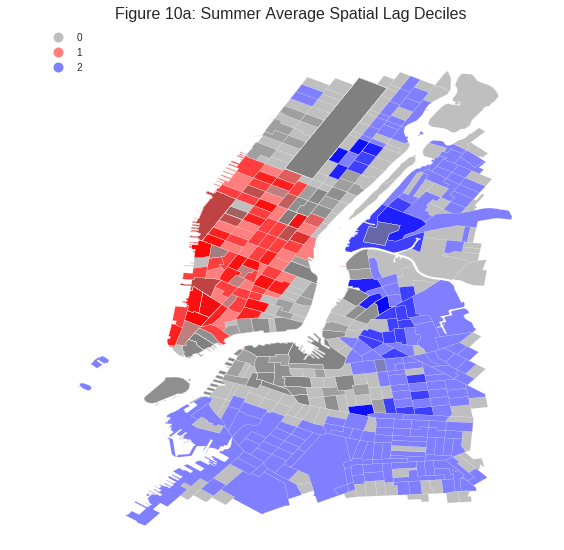

In [73]:
hcmap_summer = colors.ListedColormap(['grey', 'red', 'blue'])
hotcold_summer = hotspots_summer * 1 + coldspots_summer * 2

f, ax = plt.subplots(figsize = (9, 9))
ct_shape_SummerAve_Zoom.assign(cl = hotcold_summer).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap_summer, linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Figure 10a: Summer Average Spatial Lag Deciles", fontsize = 16)

## Figure 10a:
### The map above shows the hot and cold spots of summer average ride spatial lag for Citibike data in census tracts NYC. A hot spot (in red) indicates an area where both the census tract and its neighboring tracts have high ridership. A cold spot (in blue) indicates an area where both the census tract and its neighboring tracts have low ridership. The darker of these respective colors shows a greater significance (or correlation) as a hot/coldspot. From this map, it seems the hotspots trend in southern Manhattan (and moreso along the western shore than the east), whereas cold spots trend moreso in Queens along the East River and near where the Queensboro bridge connects in Queens, and in more central areas in Brooklyn. 

In [74]:
sig_winter = LMo_WinterRide.p_sim < 0.01
hotspots_winter = LMo_WinterRide.q == 1 * sig_winter
coldspots_winter = LMo_WinterRide.q == 3 * sig_winter
print ("Number of Winter Hotspots:", hotspots_winter.sum())
print ("Number of Winter Coldspots:", coldspots_winter.sum())

Number of Winter Hotspots: 194
Number of Winter Coldspots: 213


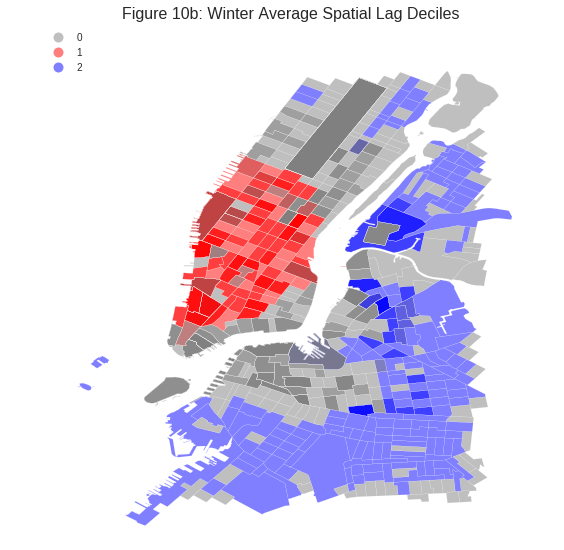

In [75]:
hcmap_winter = colors.ListedColormap(['grey', 'red', 'blue'])
hotcold_winter = hotspots_winter * 1 + coldspots_winter * 2

f, ax = plt.subplots(figsize = (9, 9))
ct_shape_WinterAve_Zoom.assign(cl = hotcold_winter).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap_winter, linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Figure 10b: Winter Average Spatial Lag Deciles", fontsize = 16)

## Figure 10b:
### The map above shows the hot and cold spots of winter average ride spatial lag for Citibike data in census tracts NYC. Like above, a hot spot (in red) indicates an area where both the census tract and its neighboring tracts have high ridership. A cold spot (in blue) indicates an area where both the census tract and its neighboring tracts have low ridership. The darker of these respective colors shows a greater significance (or correlation) as a hot/coldspot. Also similarly to the summer map, it seems the hotspots trend in southern Manhattan (and moreso along the western shore than the east), whereas cold spots trend moreso in Queens along the East River and near where the Queensboro bridge connects in Queens, and in more central areas in Brooklyn. Visually, it is difficult to compare the two seasons - from close inspection, one may notice that a new cold spot appears around where the Brooklyn Bridge connects to Brooklyn during the winter, but it is otherwise very similar.